In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df_train = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")
df = [df_train, df_test]

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


survival:   Survival
PassengerId: Unique Id of a passenger.
pclass: Ticket class    
sex:    Sex 
Age:    Age in years    
sibsp:  # of siblings / spouses aboard the Titanic  
parch:  # of parents / children aboard the Titanic  
ticket: Ticket number   
fare:   Passenger fare  
cabin:  Cabin number    
embarked:   Port of Embarkation

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
# colomne index pour les futurs merge
for tab in df:
    tab.reset_index(inplace=True)

In [9]:
# On remplace les NaN par la médiane des ages
for tab in df:
    tab["Age"].fillna(tab["Age"].median(), inplace=True)

In [10]:
df[0]["Age"].fillna(df[0]["Age"].median(), inplace=True)
df[1]["Age"].fillna(df[0]["Age"].median(), inplace=True)

In [11]:
# Trop de NaN pour Cabin, on le drop
for tab in df:
    tab.drop(["Cabin"], axis=1, inplace=True)

In [12]:
df_train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [13]:
# S est la classe la plus représentée
for tab in df:
    tab["Embarked"] = tab["Embarked"].fillna("S")

In [14]:
#One hot encoder pour Embarked
for i in range(len(df)):
    df[i] = df[i].merge(pd.get_dummies(df[i]["Embarked"], 
                         drop_first=True).reset_index(), on="index")
    df[i].drop("Embarked", axis=1, inplace=True)

In [15]:
# On remplace les données manquantes de Fare par la moyenne par class (à finir)
for tab in df:
    tab['Fare'] = tab['Fare'].fillna(tab["Fare"].mean())

In [16]:
# Le ticket semble à priori ne rien apporter : on le drop. De même pour PassagerID
for tab in df:
    tab.drop(["Ticket", "PassengerId"], axis=1, inplace=True)

In [17]:
# nombre de personne de la famille: Sibsp + Parch
for tab in df:
    tab["family_number"] = tab["Parch"] + tab["SibSp"]
    tab.drop(["Parch", "SibSp"], axis=1, inplace=True)

In [18]:
for tab in df:
    tab["Sex"] = pd.get_dummies(tab["Sex"], drop_first=True)
# 1 pour homme, 0 pour femme

In [19]:
#Pour l'instant je n'utilise pas la colomne "Name"
for tab in df:
    tab.drop("Name", axis=1, inplace=True)

In [20]:
# On enlève la colomne "index" car tous les merge ont été effectués
for tab in df:
    tab.drop("index", axis=1, inplace=True)

# Classifier

In [21]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

In [22]:
def loss(y_pred, y_true):
    return np.sum(y_pred == y_true) / len(y_pred)

In [23]:
X = df[0].drop("Survived", axis=1).values
y = df[0]["Survived"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=43)

In [24]:
X_sub = df[1].values

### Regression Logistique

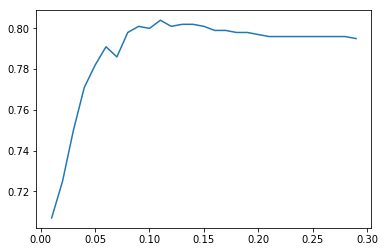

0.11

In [132]:
#Phase de test des params
param = [0.01 * i for i in range(1, 30)]
result = []
for param_test in param:
    clf_lr = LogisticRegression(C=param_test)
    scores = cross_val_score(clf_lr, X, y, cv=5, n_jobs=-1)
    result.append(round(np.mean(scores), 3))
plt.plot(param, result)
plt.show()
param[np.argmax(result)]

In [133]:
# modèle que l'on garde, avec CV
clf_lr = LogisticRegression(C=0.11)
scores = cross_val_score(clf_lr, X, y, cv=5)
round(np.mean(scores), 3)

0.804

### Decision Tree

In [55]:
clf_dt = DecisionTreeClassifier()
scores = cross_val_score(clf_dt, X, y, cv=5, n_jobs=-1)
round(np.mean(scores), 3)

0.783

### Random Forest

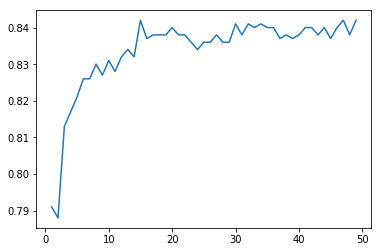

15

In [146]:
#Phase de test des params
param = [i for i in range(1, 50)]
result = []
for param_test in param:
    clf_rf = RandomForestClassifier(n_jobs=-1, n_estimators=32, max_features=0.8,
                                   max_depth=9)
    scores = cross_val_score(clf_rf, X, y, cv=5, n_jobs=-1)
    result.append(round(np.mean(scores), 3))
plt.plot(param, result)
plt.show()
param[np.argmax(result)]

In [153]:
# 0.841 avec n_estimators=32
clf_rf = RandomForestClassifier(n_jobs=-1, n_estimators=32, max_features=0.8, max_depth=9)
scores = cross_val_score(clf_rf, X, y, cv=5, n_jobs=-1)
round(np.mean(scores), 3)

0.841

### KNN

In [ ]:
neighbor = [i for i in range(1, 50)]
result = []
for n_neighbors in neighbor:
    clf_knn = KNeighborsClassifier(n_neighbors=22)
    scores = cross_val_score(clf_knn, X, y, cv=5, n_jobs=-1)
    result.append(round(np.mean(scores), 3))
plt.plot(neighbor, result)
plt.show()
neighbor[np.argmax(result)]

In [125]:
# 0.718 avec n_neighbors=22
clf_knn = KNeighborsClassifier(n_neighbors=22)
scores = cross_val_score(clf_knn, X, y, cv=5, n_jobs=-1)
round(np.mean(scores), 3)

0.718

### SVM

In [ ]:
# 0.787 avec kernel linear
clf_svm = SVC(kernel="poly")
scores = cross_val_score(clf_svm, X, y, cv=5, n_jobs=-1)
round(np.mean(scores), 3)

### Naive Bayes

In [49]:
clf_gnb = GaussianNB()
scores = cross_val_score(clf_gnb, X, y, cv=5, n_jobs=-1)
round(np.mean(scores), 3)

0.782

In [50]:
clf_mnb = MultinomialNB()
scores = cross_val_score(clf_mnb, X, y, cv=5, n_jobs=-1)
round(np.mean(scores), 3)

0.69

### Adaboost

In [113]:
# learning rate : 1.8 n_estimator: 68 score: 0.826
clf_ada = AdaBoostClassifier(learning_rate=1.8, n_estimators=68)
scores = cross_val_score(clf_ada, X, y, cv=5, n_jobs=-1)
round(np.mean(scores), 3)

0.826

### DiscriminantAnalysis

In [61]:
clf_qda = QuadraticDiscriminantAnalysis()
scores = cross_val_score(clf_qda, X, y, cv=5, n_jobs=-1)
round(np.mean(scores), 3)

0.79

In [59]:
clf_lda = LinearDiscriminantAnalysis()
scores = cross_val_score(clf_lda, X, y, cv=5, n_jobs=-1)
round(np.mean(scores), 3)

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.779

### Voting Best Classifier

In [151]:
# poids de LR, RF, ADA, QDA
weights = [0.804, 0.841, 0.826, 0.79]

In [154]:
# best : 0.83
estimators = [('lr', clf_lr), ('rf', clf_rf),('ada', clf_ada),
              ('qda', clf_qda)]
eclf1 = VotingClassifier(estimators=estimators, weights=weights, n_jobs=-1)
scores = cross_val_score(eclf1, X, y, cv=5, n_jobs=-1)
np.mean(scores)

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will re

0.8260603371814963

### On prédit que les femmes vivent et que les hommes meurent

In [ ]:
df[1].head()

In [ ]:
y_pred = (1 - df[1]["Sex"]).values

In [ ]:
y_pred = []
for i in range(len(df[1])):

        y_pred.append(1)
    else
    

# Enregistrement des données


In [155]:
clf_sub = RandomForestClassifier(n_jobs=-1, n_estimators=32, max_features=0.8, max_depth=9)
clf_sub.fit(X, y)
y_pred = clf_sub.predict(X_sub)

In [156]:
PassengerId = df_test["PassengerId"]
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
submission.to_csv('gender_submission.csv', index=False)